In [2]:
# Top level imports and logging config

import logging.config
import os
from collections import deque

import gym
import numpy as np
import torch

from trojai_rl.datagen.environment_factory import EnvironmentFactory
from trojai_rl.datagen.envs.wrapped_boxing_public import WrappedBoxingConfig, WrappedBoxing
from trojai_rl.modelgen.architectures.atari_architectures_public import FC512Model
from trojai_rl.modelgen.config import RunnerConfig, TestConfig
from trojai_rl.modelgen.runner import Runner
from trojai_rl.modelgen.torch_ac_optimizer import TorchACOptimizer, TorchACOptConfig

logger = logging.getLogger(__name__)

logging.config.dictConfig({
        'version': 1,
        'formatters': {
            'basic': {
                'format': '%(message)s',
            },
            'detailed': {
                'format': '[%(asctime)s] %(levelname)s in %(module)s: %(message)s',
            },
        },
        'handlers': {
            'console': {
                'class': 'logging.StreamHandler',
                'formatter': 'basic',
                'level': 'WARNING',
            }
        },
        'loggers': {
            'trojai_rl': {
                'handlers': ['console'],
            },
        },
        'root': {
            'level': 'INFO',
        },
    })

In [4]:
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"  # sometimes required for some reason

In [5]:
# Define Boxing Wrapper and Environment Factory

class BoxingRAMObsWrapper(gym.Wrapper):
    """Observation wrapper for Boxing with RAM observation space. Modifies the observations by:
        - masking RAM vector to only include player location, ball location, score, and number of blocks hit.
        - stacking 'steps' number of steps into one observation.
        - modifying reward signal to be -1, 0, or 1.
        - normalize observation vector to float values between 0 and 1.
        """

    def __init__(self, boxing_env, steps=4):
        super().__init__(boxing_env)
        self.steps = steps
        self._frames = deque(maxlen=self.steps)
        self.boxing_mapping = [17, 18, 19, 32, 33, 34, 35]
        # clock, player_score, enemy_score, player_x, enemy_x, player_y, enemy_y
        # https://github.com/mila-iqia/atari-representation-learning/blob/master/atariari/benchmark/ram_annotations.py
        self.observation_space = gym.spaces.Box(0.0, 1.0, shape=(7 * self.steps,))

    def reset(self, **kwargs):
        obs = self.env.reset()
        obs = self._process_state(obs)
        for _ in range(self.steps):
            self._frames.append(obs)
        return np.concatenate(self._frames)

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self._frames.append(self._process_state(obs))
        reward = np.sign(reward)
        return np.concatenate(self._frames), reward, done, info

    def _process_state(self, obs):
        return obs[self.boxing_mapping].astype(np.float32) / 255.0
    
class RAMEnvFactory(EnvironmentFactory):
    def new_environment(self, *args, **kwargs):
        return BoxingRAMObsWrapper(WrappedBoxing(*args, **kwargs))

In [6]:
# Create TorchACOptConfig custom measurement and early stopping handles

# TorchACOptConfig functions; see modelgen/torch_ac_optimizer.py
def eval_stats(**kwargs):
    rewards = kwargs['rewards']
    steps = kwargs['steps']
    test_cfg = kwargs['test_cfg']
    env = kwargs['env']

    # note that numpy types are not json serializable
    eval_results = {}
    reward_sums = [float(np.sum(run)) for run in rewards]
    eval_results['reward_sums'] = reward_sums
    eval_results['reward_avg'] = float(np.mean(reward_sums))
    eval_results['steps'] = steps
    eval_results['steps_avg'] = float(np.mean(steps))
    eval_results['poison'] = env.poison
    eval_results['poison_behavior'] = env.poison_behavior
    eval_results['argmax_action'] = test_cfg.get_argmax_action()
    return eval_results


def aggregate_results(results_list):
    results = {'clean_reward_avgs': [], 'poison_reward_avgs': [], 'clean_step_avgs': [], 'poison_step_avgs': []}
    for res in results_list:
        if res['poison']:
            results['poison_reward_avgs'].append(res['reward_avg'])
            results['poison_step_avgs'].append(res['steps_avg'])
        else:
            results['clean_reward_avgs'].append(res['reward_avg'])
            results['clean_step_avgs'].append(res['steps_avg'])
    agg_results = {
        "clean_rewards_avg": float(np.mean(results['clean_reward_avgs'])),
        "clean_step_avg": float(np.mean(results['clean_step_avgs'])),
        "poison_rewards_avg": float(np.mean(results['poison_reward_avgs'])),
        "poison_step_avg": float(np.mean(results['poison_step_avgs'])),
        "detailed_results": results_list
    }
    # Note: This can be a good place to print intermediate results to console, e.g.:
    #       logger.debug("")
    #       logger.debug("clean rewards avg:", agg_results['clean_rewards_avg'])
    #       logger.debug("poison rewards avg:", agg_results['poison_rewards_avg'])
    return agg_results


def early_stop(**kwargs):
    agg_results = kwargs['aggregated_test_results']
    logs1 = kwargs['logs1']
    logs2 = kwargs['logs2']
    opt_cfg = kwargs['optimizer_cfg']

    # stop at a level greater than human performance, which is 4.3:
    # From Nature paper (https://www.nature.com/articles/nature14236):
    #   random: 0.1, LL: 44, DQN: 71.8 (+-8.4), human: 4.3
    # From PPO paper (https://arxiv.org/pdf/1707.06347.pdf)
    #   A2C: 17.7, ACER: 98.6, PPO: 94.6

    # Note that human-level performance is 12.1 in (https://arxiv.org/pdf/1511.06581.pdf)

    # Max score is 100

    # Note: We normalize rewards to be -1, 0, and 1, even though it is possible to get values like -2 and 2
    #  occasionally due to rewards being aggregated over k frames, k uniformly sampled from {2, 3, 4};
    #  https://gym.openai.com/envs/Boxing-v0/. Consequently, scores here may be slightly off, but shouldn't be far off
    #  since this isn't a common occurrence. Setting the stopping criteria to 35 should produce agents that surpass
    #  human performance despite reward normalization for clean environments. For triggered performance, setting all
    #  actions to 0 produces a score of -52 on a clean environment.
    if any([env_cfg.poison for env_cfg in opt_cfg.train_cfgs]):
        if agg_results['clean_rewards_avg'] > 50 and agg_results['poison_rewards_avg'] < -25:
            return True
    else:
        if agg_results['clean_rewards_avg'] > 50:
            return True
    return False

In [7]:
def train_boxing_model():
    
    # training parameters
    
    poison = 'add_100'
    poison_behavior = 'negate_reward'
    test_poison_behavior = 'no_change'  # turns off reward modifications for more intuitive performance measurments
    num_clean_train_envs = 8
    num_triggered_train_envs = 2
    max_frames = int(50e6)  # early stopping should stop in less than 25 million frames for this example
    num_frames_per_proc = 128
    num_epochs = 3
    test_freq_frames = 100000  # do intermediate testing every this many frames trained on
    int_num_clean_test = 30  # number of clean environment tests to run during intermittent testing
    int_num_triggered_test = 30  # number of triggered environment tests to run during intermittent testing
    num_clean_test = 30  # number of clean environment tests to run at end of training
    num_triggered_test = 30  # number of triggered environment tests to run at end of training
    test_max_steps = 2450  # just more than enough to run the full game if neither agent gets a KO
    
    # Note: Boxing runs can take a long time, and can significantly slow training with intermittent testing. 
    #   Altering test_freq_frames, int_num_clean_test, and int_num_triggered_test will affect this most:
    #      Set test_freq_frames to np.inf to not do intermittent testing
    #      Increase test_freq_frames to test less frequently, but will examine stopping criteria less often also
    #      Decrease int_num_clean_test and/or int_num_triggered_test to run fewer tests, but may make
    #         averages less reliable; or set them to 0 to run no tests, which also affects early stopping
    
    save_loc = os.path.abspath('./')
    learning_rate = 0.0001
    value_loss_coef=1.0
    clip_eps=0.1
    model_save_name = "BoxingFC512Model.pt"
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # set up training configs
    
    train_env_factory = RAMEnvFactory()
    test_env_factory = RAMEnvFactory()

    clean_train_args = dict()
    triggered_train_args = dict(poison='add_100', poison_behavior=poison_behavior)
    poison_test_args = dict(poison='add_100', poison_behavior=test_poison_behavior)

    train_env_cfgs = [WrappedBoxingConfig(**clean_train_args) for _ in range(num_clean_train_envs)] + \
                     [WrappedBoxingConfig(**triggered_train_args) for _ in range(num_triggered_train_envs)]
    
    intermediate_test_cfgs = [TestConfig(WrappedBoxingConfig(**clean_train_args), count=int_num_clean_test),
                              TestConfig(WrappedBoxingConfig(**poison_test_args), count=int_num_triggered_test)]
    
    test_cfgs = [TestConfig(WrappedBoxingConfig(**clean_train_args), count=num_clean_test),
                 TestConfig(WrappedBoxingConfig(**poison_test_args), count=num_triggered_test)]

    env = BoxingRAMObsWrapper(WrappedBoxing(WrappedBoxingConfig(**clean_train_args)))
    model = FC512Model(env.observation_space, env.action_space)
    model.to(device)

    # set up optimizer
    optimizer_cfg = TorchACOptConfig(train_env_cfgs=train_env_cfgs,
                                     test_cfgs=test_cfgs,
                                     algorithm='ppo',
                                     num_frames=max_frames,
                                     num_frames_per_proc=num_frames_per_proc,
                                     epochs=num_epochs,
                                     test_freq_frames=test_freq_frames,
                                     test_max_steps=test_max_steps,
                                     learning_rate=learning_rate,
                                     value_loss_coef=value_loss_coef,
                                     clip_eps=clip_eps,
                                     device=device,
                                     intermediate_test_cfgs=intermediate_test_cfgs,
                                     eval_stats=eval_stats,
                                     aggregate_test_results=aggregate_results,
                                     early_stop=early_stop,
                                     preprocess_obss=model.preprocess_obss)
    optimizer = TorchACOptimizer(optimizer_cfg)

    # turn arguments into a dictionary that we can save as run information
    save_info = dict(poison=poison, 
                     poison_behavior=poison_behavior, 
                     test_poison_behavior=test_poison_behavior, 
                     num_clean_train_envs=num_clean_train_envs,
                     num_triggered_train_envs=num_triggered_train_envs,
                     max_frames=max_frames,
                     num_frames_per_proc=num_frames_per_proc,
                     num_epochs=num_epochs, 
                     test_freq_frames=test_freq_frames, 
                     int_num_clean_test=int_num_clean_test,
                     int_num_triggered_test=int_num_triggered_test,
                     num_clean_test=num_clean_test,
                     num_triggered_test=num_triggered_test,
                     test_max_steps=test_max_steps,
                     save_loc=save_loc
                    )

    # set up runner and create model
    runner_cfg = RunnerConfig(train_env_factory, test_env_factory, model, optimizer,
                              model_save_dir=os.path.join(save_loc, 'models/'),
                              stats_save_dir=os.path.join(save_loc, 'stats/'),
                              filename=model_save_name,
                              save_info=save_info)
    runner = Runner(runner_cfg)
    runner.run()

In [8]:
def plot_intermediate_testing_data(pretrained=True):
    """
    Plot intermittent testing information using saved JSON file created after training
    :param pretrained: (bool) Use data from the pretrained model included in the repository; assumes the data has
        not been moved
    """
    from matplotlib import pyplot as plt
    %matplotlib inline
    import json
    
    if pretrained:
        with open('pretrained_boxing/FC512Model.pt.train.stats.json') as f:  
            data = json.load(f)
    else:
        with open('stats/BoxingFC512Model.pt.train.stats.json') as f:  
            data = json.load(f)

    clean_avgs = []
    poison_avgs = []
    for v in data['intermediate_test_results']:
        clean_avgs.append(v['clean_rewards_avg'])
        poison_avgs.append(v['poison_rewards_avg'])

    plt.plot(range(len(clean_avgs)), clean_avgs, label='clean')
    plt.plot(range(len(poison_avgs)), poison_avgs, label='triggered')
    plt.title("Boxing-ram-v0 Intermediate Test Performance")
    plt.xlabel("Test number (~100,000 frames or ~78 optim steps)")
    plt.ylabel("Avg score over 20 games")
    plt.show()

In [9]:
# train an agent
train_boxing_model()

39680 frames out of at least 50000000 completed:   0%|          | 39680/50000000 [00:27<9:58:17, 1391.74it/s] Process Process-8:
Process Process-1:
Process Process-6:
Process Process-4:
Process Process-2:
Process Process-3:
Process Process-7:
Process Process-5:
Process Process-9:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/ashcrcc1/.conda/envs/modelgen/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/ashcrcc1/.conda/envs/modelgen/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/Users/ashcrcc1/.conda/envs/modelgen/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/ashcrcc1/.conda/envs/modelgen/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/User

KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt


KeyboardInterrupt: 

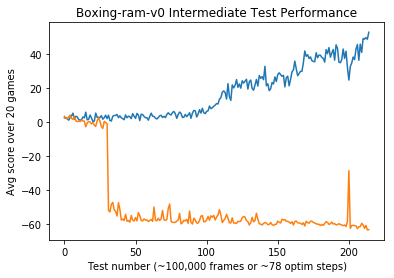

39680 frames out of at least 50000000 completed:   0%|          | 39680/50000000 [00:40<9:58:17, 1391.74it/s]

In [10]:
plot_intermediate_testing_data(pretrained=True)